<center><font color = '#FFA500' size = '8%'>References</font></center>
<ul>
  <li>https://www.worldometers.info/coronavirus/</li>
  <li>https://github.com/CSSEGISandData/COVID-19</li>
  <li>https://github.com/imdevskp/covid_19_jhu_data_web_scrap_and_cleaning</li>
  <li>https://www.niaid.nih.gov/news-events/novel-coronavirus-sarscov2-images</li>
  <li>https://blogs.cdc.gov/publichealthmatters/2019/04/h1n1/</li>
  <li>https://www.kaggle.com/imdevskp/corona-virus-report</li>
  <li>https://www.kaggle.com/imdevskp/mers-outbreak-dataset-20122019</li>
  <li>https://www.kaggle.com/imdevskp/ebola-outbreak-20142016-complete-dataset</li>
  <li>https://www.kaggle.com/imdevskp/h1n1-swine-flu-2009-pandemic-dataset</li>
  <li>https://www.kaggle.com/imdevskp/sars-outbreak-2003-complete-dataset</li>
  <li>https://www.kaggle.com/imdevskp/hiv-aids-dataset</li>
  <li>https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6</li>
  <li>https://www.worldometers.info/coronavirus/</li>
  <li>https://app.flourish.studio/visualisation/1571387</li>
</ul>

<center><font color = '#FFA500' size = '8%'>Data Exploration</font></center>

In [93]:
# Importing Required Libraries.
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [94]:
province_data = pd.read_csv('country_wise_latest.csv')
day_wise = pd.read_csv('day_wise.csv')
group_data = pd.read_csv('full_grouped.csv')
usa_data = pd.read_csv('usa_county_wise.csv')
world_data = pd.read_csv('worldometer_data.csv')
# pd.read_csv('covid_19_clean_complete.csv')

In [95]:
import torch
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")
model = SamModel.from_pretrained("wanglab/medsam-vit-base").to(device)

<center><font color = '#FFA500' size = '4%'>User-Defined Functions for Outliers</font></center>

In [96]:
#region Outliers

def find_outliers(data_frame, columns = None) -> np.ndarray:
  '''
  Find the indices of outliers in a given DataFrame using the interquartile range (IQR) method.
  ---
  # Parameters:
  - data_frame (pandas.DataFrame): The input DataFrame.
  - columns (list or None): A list of column names to consider for outlier detection.
    If None, all numerical columns in the DataFrame will be considered.
  ---
  # Returns:
  - outliers_indices (numpy.ndarray): An array containing the indices of the outliers.
  '''

  # Parameter Validator.
  if columns is None:
    columns = data_frame.select_dtypes(include=[np.number]).columns.tolist()

  outliers_indices = np.array([], dtype=int)

  for column in columns:
    # Convert column to numpy array for consistent handling.
    data = data_frame[column].values

    # Calculate the first quartile (Q1) and third quartile (Q3).
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    # Calculate the interquartile range (IQR).
    iqr = q3 - q1

    # Define the lower and upper bounds for outliers.
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Find the indices of outliers for the current column.
    column_outliers_indices = np.where((data < lower_bound) | (data > upper_bound))[0]

    # Concatenate indices to the overall outliers_indices array.
    outliers_indices = np.concatenate((outliers_indices, column_outliers_indices))

  # Remove duplicate indices and return.
  return np.unique(outliers_indices)

def remove_outliers_iqr(data_frame, columns = None) -> pd.DataFrame:
  '''
  Remove outliers from a given DataFrame using the interquartile range (IQR) method.
  ---
  # Parameters:
  - data_frame (pandas.DataFrame): The input DataFrame.
  - columns (list or None): A list of column names to consider for outlier removal.
    If None, all numerical columns in the DataFrame will be considered.
  ---
  # Returns:
  - data_frame_without_outliers (pandas.DataFrame): The DataFrame with outliers removed.
  '''

  # Parameter validator.
  if columns is None:
    columns = data_frame.select_dtypes(include=[np.number]).columns.tolist()

  data_frame_without_outliers = data_frame.copy()

  for column in columns:
    # Find the indices of outliers for the current column.
    outliers_indices = find_outliers(data_frame, columns=[column])

    # Remove outliers from the current column.
    data_frame_without_outliers[column].iloc[outliers_indices] = np.nan

  # Drop rows with NaN values after removing outliers.
  data_frame_without_outliers = data_frame_without_outliers.dropna()

  return data_frame_without_outliers

def remove_outliers_median_imputation(data_frame, columns = None) -> pd.DataFrame:
  '''
  Remove outliers from a given DataFrame using median imputation.
  ---
  # Parameters:
  - data_frame (pandas.DataFrame): The input DataFrame.
  - columns (list or None): A list of column names to consider for outlier removal.
    If None, all numerical columns in the DataFrame will be considered.
  ---
  # Returns:
  - data_frame_without_outliers (pandas.DataFrame): The DataFrame with outliers removed using median imputation.
  '''

  # Parameter Validator.
  if columns is None:
      columns = data_frame.select_dtypes(include=[np.number]).columns.tolist()

  data_frame_without_outliers = data_frame.copy()

  for column in columns:
      # Find the indices of outliers for the current column
      outliers_indices = find_outliers(data_frame, columns=[column])

      # Impute outliers with the median of the column
      median_value = data_frame[column].median()
      data_frame_without_outliers[column].iloc[outliers_indices] = median_value

  return data_frame_without_outliers

def remove_outliers(data_frame, strategy = 'median_imputation', columns = None) -> pd.DataFrame:
  '''
  Remove outliers from a given DataFrame based on the specified strategy.
  ---
  # Parameters:
  - data_frame (pandas.DataFrame): The input DataFrame.
  - strategy (str): The strategy to use for outlier removal. Options: 'iqr' or 'median_imputation'.
  - columns (list or None): A list of column names to consider for outlier removal.
    If None, all numerical columns in the DataFrame will be considered.
  ---
  # Returns:
  - data_frame_without_outliers (pandas.DataFrame): The DataFrame with outliers removed based on the specified strategy.
  '''

  # Parameter Validator.
  if strategy not in ['iqr', 'median_imputation']:
      raise ValueError("Invalid strategy. Choose either 'iqr' or 'median_imputation'.")

  # Switching based on the different outlier removal methods.
  if strategy == 'iqr':
      return remove_outliers_iqr(data_frame, columns)
  elif strategy == 'median_imputation':
      return remove_outliers_median_imputation(data_frame, columns)

def plot_outlier_boxplots(data_frame, columns = None) -> None:
  '''
  Plot boxplots for specified columns in a DataFrame, highlighting outliers.
  ---
  # Parameters:
  - data_frame (pandas.DataFrame): The input DataFrame.
  - columns (list or None): A list of column names to plot boxplots.
    If None, boxplots will be plotted for all numerical columns.
  ---
  # Returns:
  - None
  '''

  # Parameter Validator.
  if columns is None:
    columns = data_frame.select_dtypes(include=[np.number]).columns.tolist()

  # Setting the Figure Size.
  plt.figure(figsize=(15, data_frame.shape[1] * 3))

  for i, column in enumerate(columns, start = 1):
    plt.subplot(len(columns), 1, i)
    sns.boxplot(x = data_frame[column], color = '#FFA500')
    plt.title(f'Boxplot for { column }')

  # Highlight outliers with red markers.
  outliers_indices = find_outliers(data_frame, columns = [column])
  outliers = data_frame[column].iloc[outliers_indices]
  plt.scatter(outliers_indices, outliers, color = 'red', marker = 'o', label = 'Outliers')

  plt.legend()

  # Plotting the plot.
  plt.tight_layout()
  plt.show()

#endregion

#region Missing Values

def fill_missing_values(data_frame, method = 'ffill') -> pd.DataFrame:
  '''
  Fill missing values in a given DataFrame using forward fill.
  ---
  # Parameters:
  - data_frame (pandas.DataFrame): The input DataFrame.
  - method (str): Method as used in fillna() method for filling the NaN values.
  ---
  # Returns:
  - filled_data_frame (pandas.DataFrame): The DataFrame with missing values filled using forward fill.
  '''

  filled_data_frame = data_frame.copy()
  filled_data_frame.fillna(method = method, inplace = True)
  return filled_data_frame

#endregion

#region Plots

def plot_charts(x_data, y_data, x_label, y_label, pie_labels, title, figsize = (15, 6)) -> None:
  '''
  Plots pie and bar charts using subplots.
  ---
  # Parameters:
  - x_data (list or array-like): X-axis data.
  - y_data (list or array-like): Y-axis data.
  - x_label (str): Label for x-axis.
  - x_label (str): Label for y-axis.
  - pie_labels (list or array-like): Labels for pie chart.
  - title (str): Title of the combined chart.
  - figsize (tuple): Figure size in inches. Default is (12, 6).
  ---
  # Returns:
  - None
  ---
  # Example:
  >>> x_data = [1, 2, 3, 4, 5]
  >>> y_data = [10, 20, 15, 25, 30]
  >>> pie_labels = ['A', 'B', 'C', 'D', 'E']
  >>> x_label = 'X-axis Label'
  >>> y_label = 'Y-axis Label'
  >>> title = 'Custom Chart'
  >>> plot_pie_and_bar_subplots(x_data, y_data, pie_labels, x_label, y_label, title)
  '''

  # Setting figure size before plotting the charts.
  plt.figure(figsize = figsize)

  # Subplot with 1 row and 2 columns.
  plt.subplot(1, 2, 1)

  # Pie Chart.
  plt.pie(x = y_data,
          labels = pie_labels,
          autopct = '%.2f%%',
          shadow = True,
          explode = (([0.1]) + ([0] * (len(x_data) - 1))),
          wedgeprops = dict(width = 0.6))

  # Chart Decoration for Pie Chart.
  plt.xlabel(x_label)
  plt.title(title)

  # Subplot with 1 row and 2 columns.
  plt.subplot(1, 2, 2)

  # Bar Chart.
  plt.bar(x = x_data,
          height = y_data)

  # Display actual values on top of the bars
  for i, value in enumerate(y_data):
    plt.text(i, value + 1, str(int(value)), ha = 'center', va = 'bottom')

  # Chart Decoration for Bar Chart.
  plt.xticks(rotation = 90)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Adjust layout to prevent overlap.
  plt.tight_layout()

  # Display the subplots.
  plt.show()

#endregion

In [97]:
# Initial look on the data.
world_data

,Country/Region,Continent,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,WHO Region
0,USA,North America,3.311981e+08,5032179,NaN,162804.0,NaN,2576668.0,NaN,2292707.0,18296.0,15194.0,492.0,63139605.0,190640.0,Americas
1,Brazil,South America,2.127107e+08,2917562,NaN,98644.0,NaN,2047660.0,NaN,771258.0,8318.0,13716.0,464.0,13206188.0,62085.0,Americas
2,India,Asia,1.381345e+09,2025409,NaN,41638.0,NaN,1377384.0,NaN,606387.0,8944.0,1466.0,30.0,22149351.0,16035.0,South-EastAsia
3,Russia,Europe,1.459409e+08,871894,NaN,14606.0,NaN,676357.0,NaN,180931.0,2300.0,5974.0,100.0,29716907.0,203623.0,Europe
4,South Africa,Africa,5.938157e+07,538184,NaN,9604.0,NaN,387316.0,NaN,141264.0,539.0,9063.0,162.0,3149807.0,53044.0,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,Montserrat,North America,4.992000e+03,13,NaN,1.0,NaN,10.0,NaN,2.0,NaN,2604.0,200.0,61.0,12220.0,NaN
205,Caribbean Netherlands,North America,2.624700e+04,13,NaN,NaN,NaN,7.0,NaN,6.0,NaN,495.0,NaN,424.0,16154.0,NaN
206,Falkland Islands,South America,3.489000e+03,13,NaN,NaN,NaN,13.0,NaN,0.0,NaN,3726.0,NaN,1816.0,520493.0,NaN
207,Vatican City,Europe,8.010000e+02,12,NaN,NaN,NaN,12.0,NaN,0.0,NaN,14981.0,NaN,NaN,NaN,Europe


In [98]:
# Understanding the technical details regarding the dataset.
world_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country/Region    209 non-null    object 
 1   Continent         208 non-null    object 
 2   Population        208 non-null    float64
 3   TotalCases        209 non-null    int64  
 4   NewCases          4 non-null      float64
 5   TotalDeaths       188 non-null    float64
 6   NewDeaths         3 non-null      float64
 7   TotalRecovered    205 non-null    float64
 8   NewRecovered      3 non-null      float64
 9   ActiveCases       205 non-null    float64
 10  Serious,Critical  122 non-null    float64
 11  Tot Cases/1M pop  208 non-null    float64
 12  Deaths/1M pop     187 non-null    float64
 13  TotalTests        191 non-null    float64
 14  Tests/1M pop      191 non-null    float64
 15  WHO Region        184 non-null    object 
dtypes: float64(12), int64(1), object(3)
memory u

<center><font color = '#FFA500' size = '6%'>Feature Description</font></center>

<b>Country/Region:</b> This is the name of the country or geographic region associated with the COVID-19 data in the dataset.

<b>Continent:</b> This is the continent on which the country or region is located. For example, North America, Europe, Asia, etc.

<b>Population:</b> The total population of the country or region.

<b>TotalCases:</b> This is the total number of COVID-19 cases reported in the country or region to date.

<b>NewCases:</b> This is the number of new COVID-19 cases reported in a specific time period, often daily or weekly.

<b>TotalDeaths:</b> Total COVID-19 deaths reported in the country or region to date.

<b>NewDeaths:</b> This is the number of new deaths from COVID-19 reported in a specific time period, often daily or weekly.

<b>TotalRecovered:</b> The total number of patients who have recovered from COVID-19 in the country or region.

<b>NewRecovered:</b> The number of patients who recovered from COVID-19 in a specific time period, often daily or weekly.

<b>ActiveCases:</b> The current number of active cases of COVID-19, which is the difference between total cases, total deaths and total recoveries.

<b>Serious, Critical:</b> Number of serious or critical cases requiring intensive medical care.

<b>Tot Cases/1M pop:</b> This is the total number of COVID-19 cases per million population.

<b>Deaths/1M pop:</b> This is the total number of deaths from COVID-19 per million population.

<b>TotalTests:</b> The total number of COVID-19 tests that have been carried out in the country or region.

<b>Tests/1M pop:</b> This is the total number of COVID-19 tests per million residents.

<b>WHO Region:</b> A region defined by the World Health Organization (WHO) that includes that country or region within the framework of that organization.

<font color = '#FFA500' size = '4%'>Missing Values</font>

In [99]:
# Dealing with the missing values using Forward-Fill method.
world_data = fill_missing_values(world_data)
world_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country/Region    209 non-null    object 
 1   Continent         209 non-null    object 
 2   Population        209 non-null    float64
 3   TotalCases        209 non-null    int64  
 4   NewCases          204 non-null    float64
 5   TotalDeaths       209 non-null    float64
 6   NewDeaths         204 non-null    float64
 7   TotalRecovered    209 non-null    float64
 8   NewRecovered      204 non-null    float64
 9   ActiveCases       209 non-null    float64
 10  Serious,Critical  209 non-null    float64
 11  Tot Cases/1M pop  209 non-null    float64
 12  Deaths/1M pop     209 non-null    float64
 13  TotalTests        209 non-null    float64
 14  Tests/1M pop      209 non-null    float64
 15  WHO Region        209 non-null    object 
dtypes: float64(12), int64(1), object(3)
memory u

<font color = '#FFA500' size = '4%'>Outliers</font>

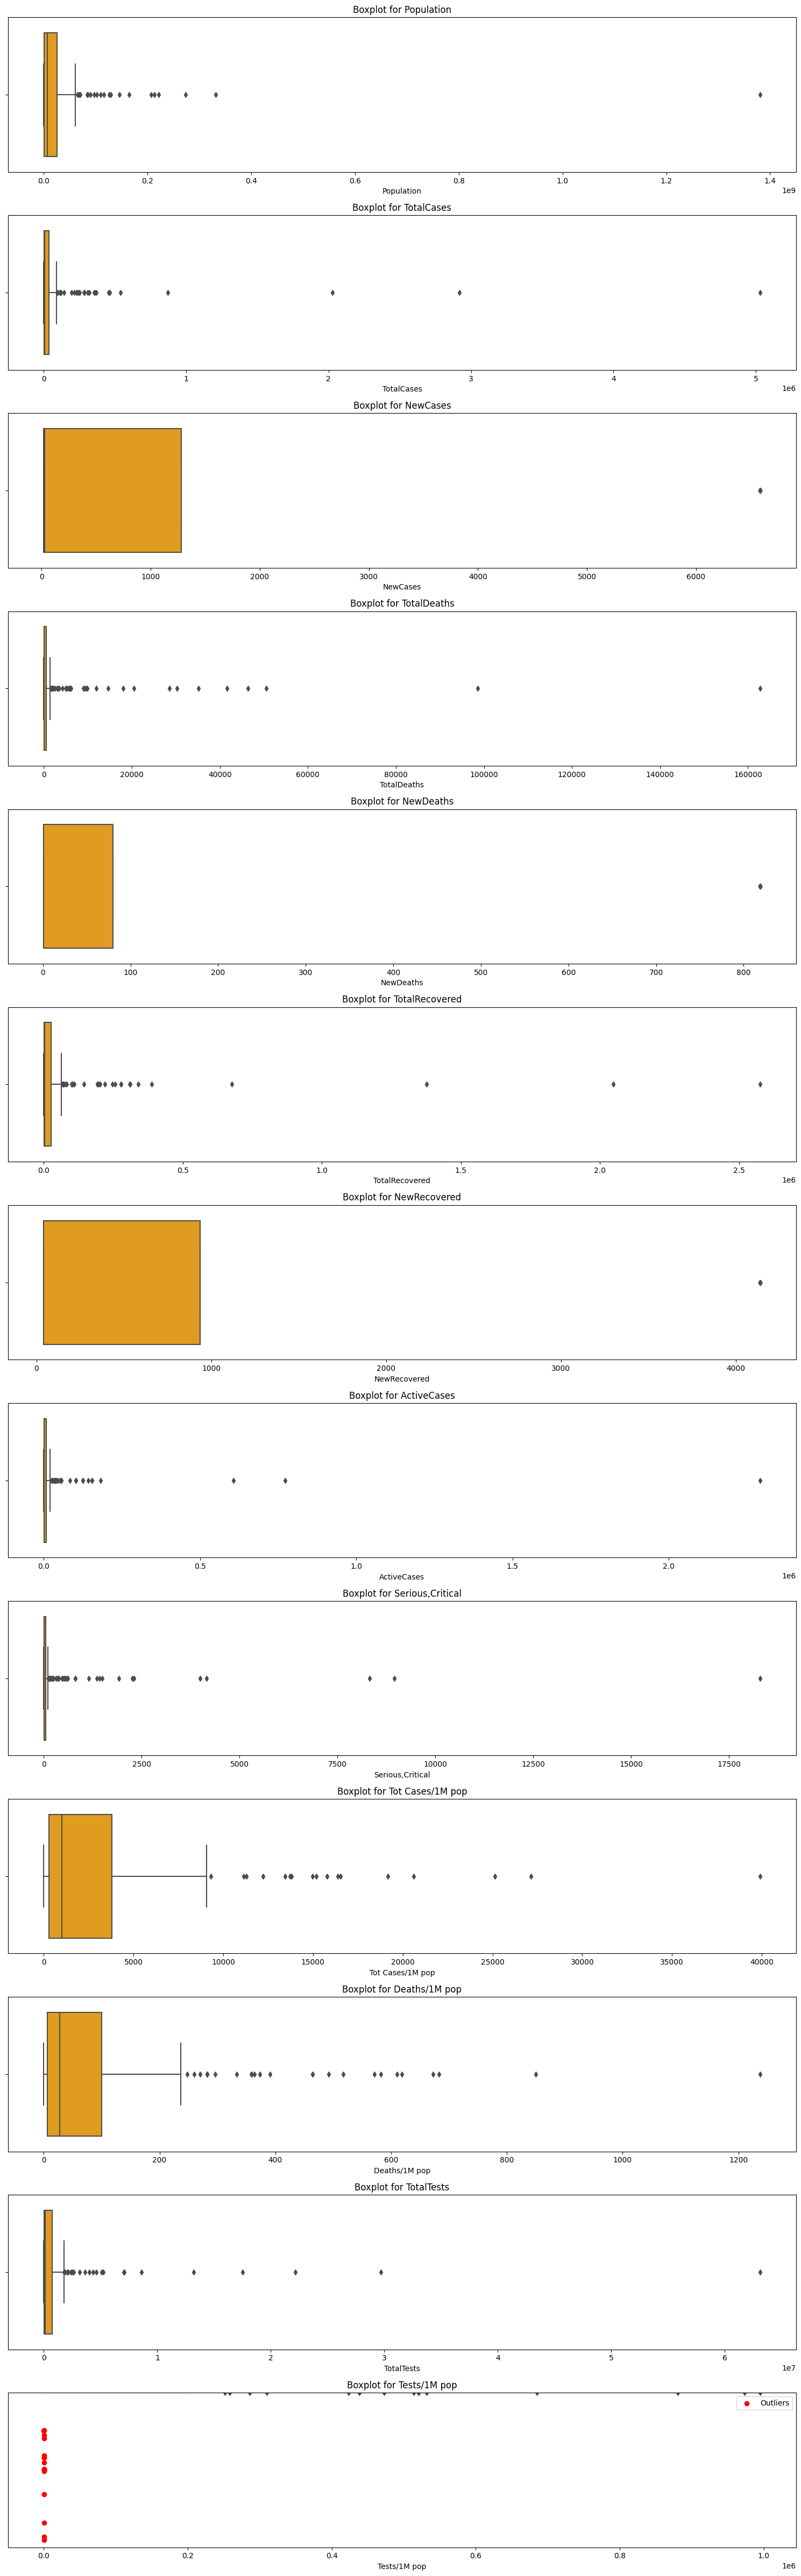

In [100]:
# Field: World-Data.
plot_outlier_boxplots(world_data)

<ipython-input-96-8f0459503a11>:102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-96-8f0459503a11>:102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-96-8f0459503a11>:102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-96-8f0459503a11>:102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

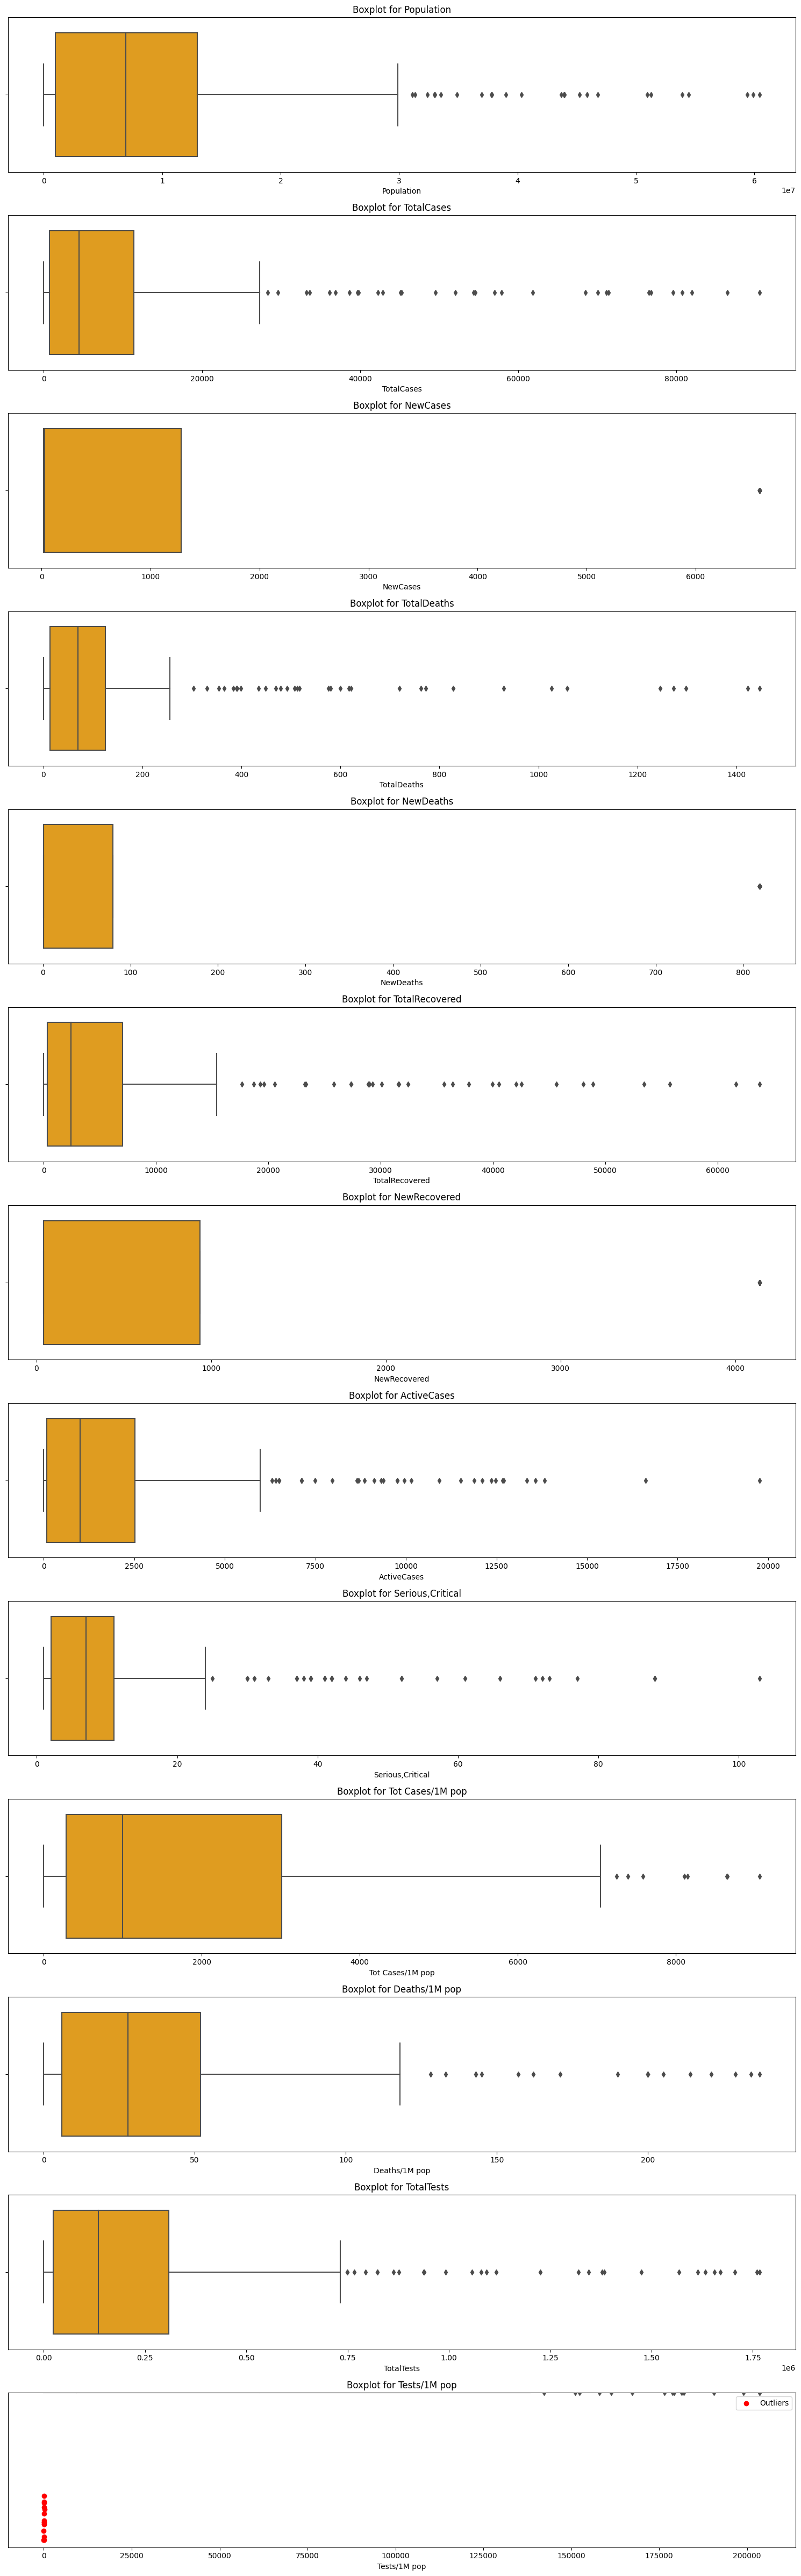

In [101]:
# Removing Outliers using Quartile Method.
world_data = remove_outliers(world_data)

# Checking for outliers.
plot_outlier_boxplots(world_data)

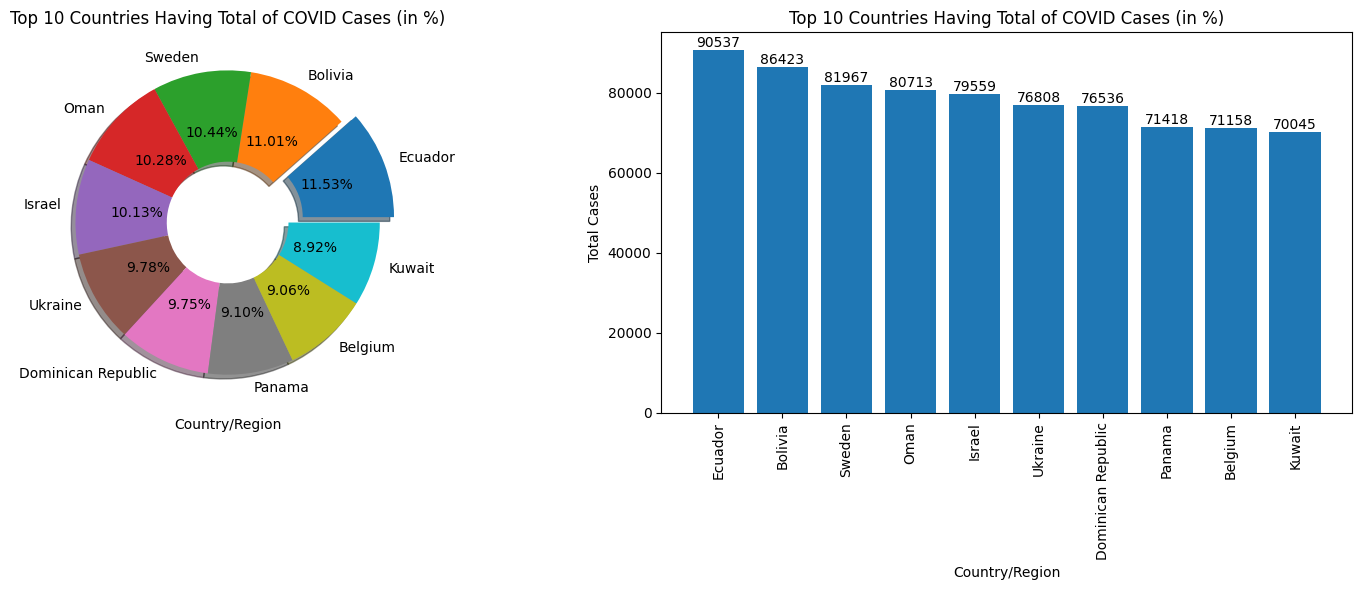

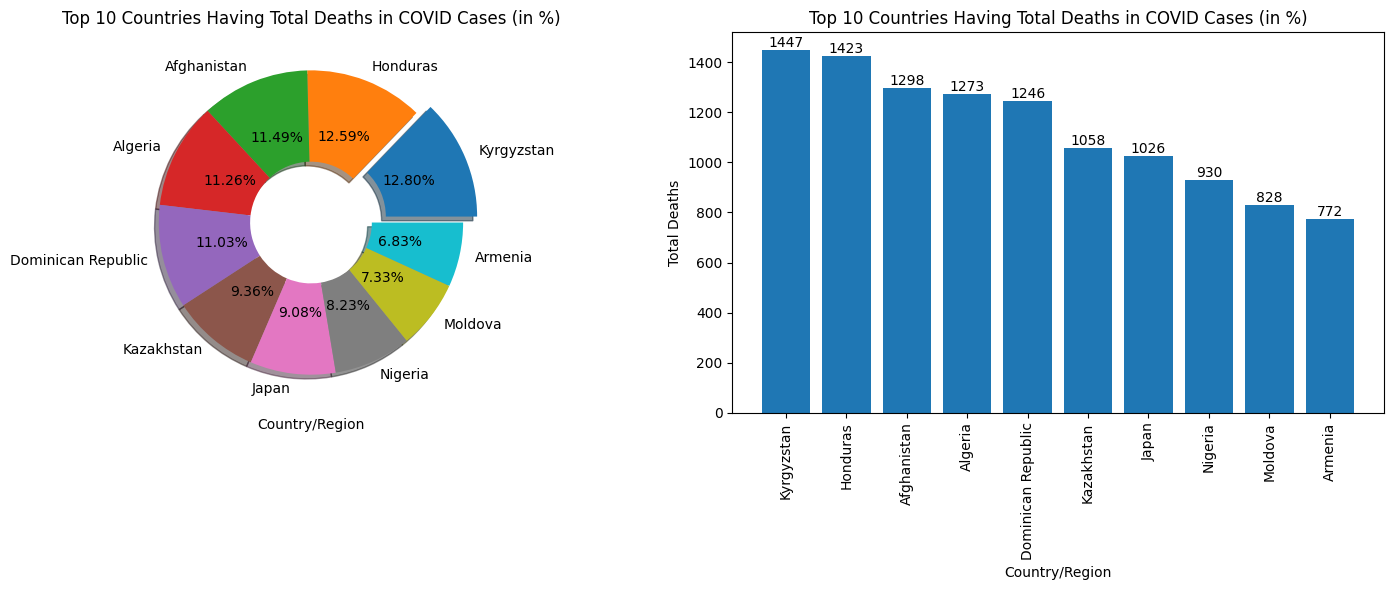

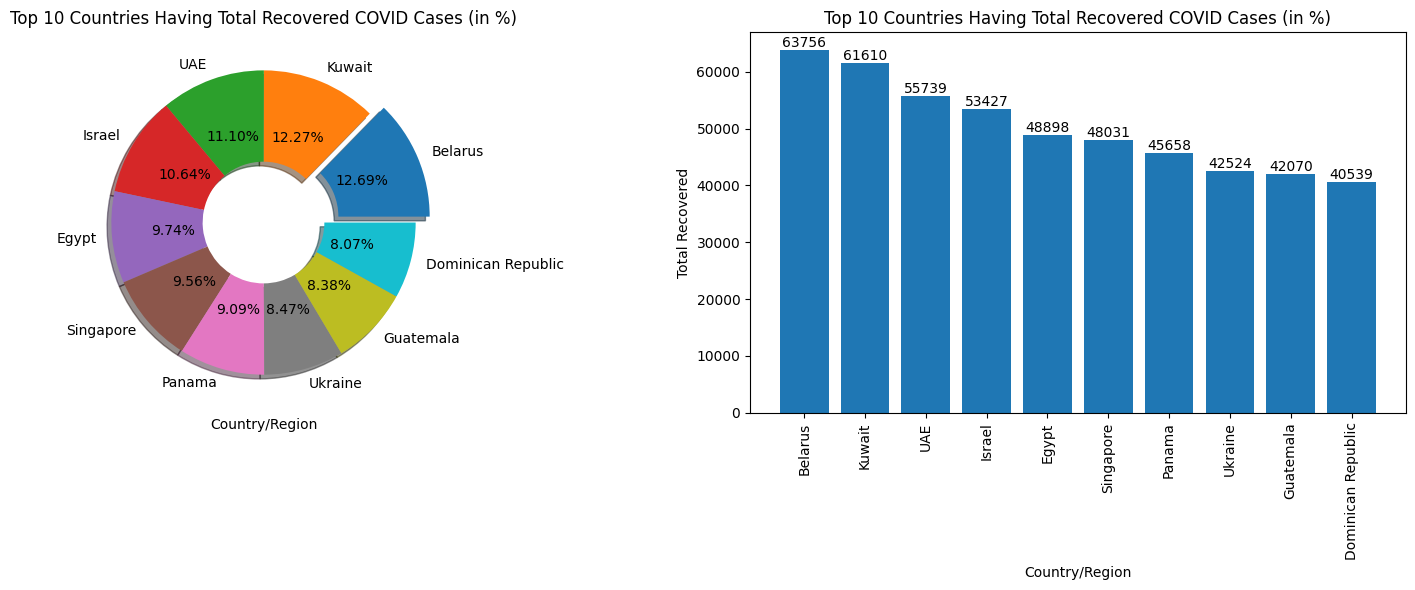

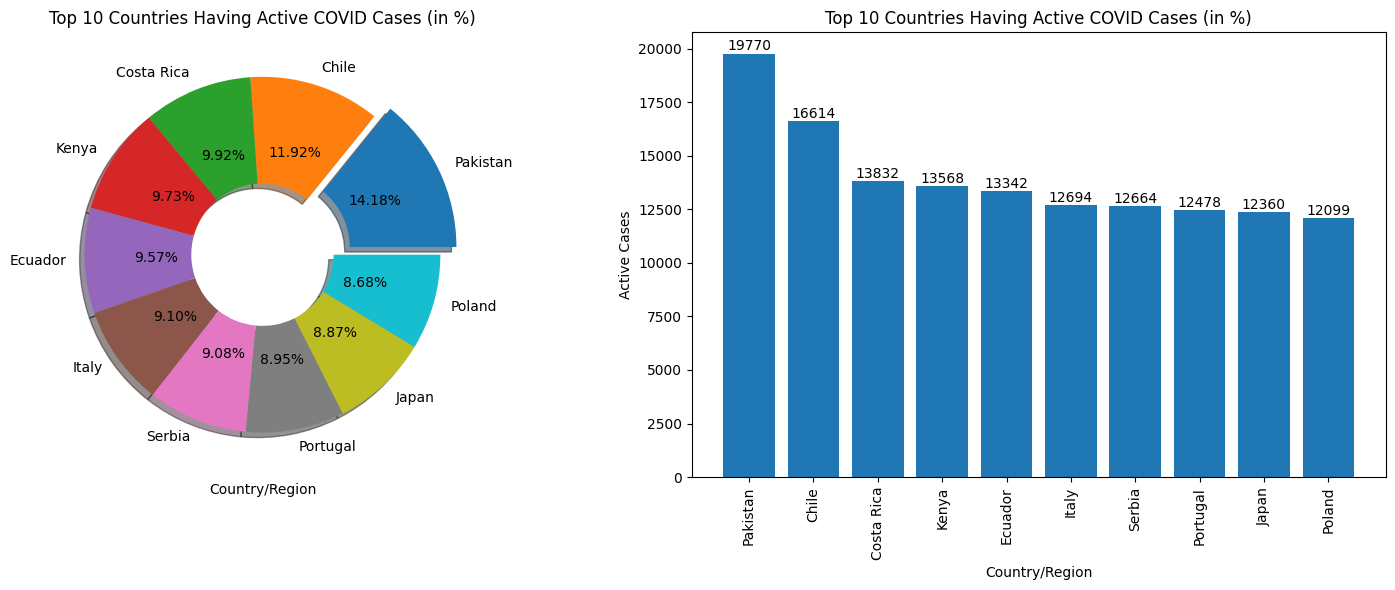

In [102]:
# Fields - TotalCases, TotalDeaths, TotalRecovered, and ActiveCases.

# Total Cases.
plot_charts(x_data = world_data.sort_values(by = 'TotalCases', ascending = False).iloc[ : 10]['Country/Region'],
            y_data = world_data.sort_values(by = 'TotalCases', ascending = False).iloc[ : 10].TotalCases,
            x_label = 'Country/Region',
            y_label = 'Total Cases',
            pie_labels = world_data.sort_values(by = 'TotalCases', ascending = False).iloc[ : 10]['Country/Region'],
            title = 'Top 10 Countries Having Total of COVID Cases (in %)')

print()

# Total Deaths.
plot_charts(x_data = world_data.sort_values(by = 'TotalDeaths', ascending = False).iloc[ : 10]['Country/Region'],
            y_data = world_data.sort_values(by = 'TotalDeaths', ascending = False).iloc[ : 10].TotalDeaths,
            x_label = 'Country/Region',
            y_label = 'Total Deaths',
            pie_labels = world_data.sort_values(by = 'TotalDeaths', ascending = False).iloc[ : 10]['Country/Region'],
            title = 'Top 10 Countries Having Total Deaths in COVID Cases (in %)')

print()

# # Total Recovered.
plot_charts(x_data = world_data.sort_values(by = 'TotalRecovered', ascending = False).iloc[ : 10]['Country/Region'],
            y_data = world_data.sort_values(by = 'TotalRecovered', ascending = False).iloc[ : 10].TotalRecovered,
            x_label = 'Country/Region',
            y_label = 'Total Recovered',
            pie_labels = world_data.sort_values(by = 'TotalRecovered', ascending = False).iloc[ : 10]['Country/Region'],
            title = 'Top 10 Countries Having Total Recovered COVID Cases (in %)')

print()

# Active Cases.
plot_charts(x_data = world_data.sort_values(by = 'ActiveCases', ascending = False).iloc[ : 10]['Country/Region'],
            y_data = world_data.sort_values(by = 'ActiveCases', ascending = False).iloc[ : 10].ActiveCases,
            x_label = 'Country/Region',
            y_label = 'Active Cases',
            pie_labels = world_data.sort_values(by = 'ActiveCases', ascending = False).iloc[ : 10]['Country/Region'],
            title = 'Top 10 Countries Having Active COVID Cases (in %)')

<font color = '#FFA500'>What were the trajectories of confirmed deaths, recoveries, and active cases?</font>

In [103]:
# First look on the dataset.
day_wise

,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,2020-01-22,555,17,28,510,0,0,0,3.06,5.05,60.71,6
1,2020-01-23,654,18,30,606,99,1,2,2.75,4.59,60.00,8
2,2020-01-24,941,26,36,879,287,8,6,2.76,3.83,72.22,9
3,2020-01-25,1434,42,39,1353,493,16,3,2.93,2.72,107.69,11
4,2020-01-26,2118,56,52,2010,684,14,13,2.64,2.46,107.69,13
...,...,...,...,...,...,...,...,...,...,...,...,...
183,2020-07-23,15510481,633506,8710969,6166006,282756,9966,169714,4.08,56.16,7.27,187
184,2020-07-24,15791645,639650,8939705,6212290,281164,6144,228736,4.05,56.61,7.16,187
185,2020-07-25,16047190,644517,9158743,6243930,255545,4867,219038,4.02,57.07,7.04,187
186,2020-07-26,16251796,648621,9293464,6309711,204606,4104,134721,3.99,57.18,6.98,187


In [104]:
# Understanding the technical details regarding the dataset.
day_wise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    188 non-null    object 
 1   Confirmed               188 non-null    int64  
 2   Deaths                  188 non-null    int64  
 3   Recovered               188 non-null    int64  
 4   Active                  188 non-null    int64  
 5   New cases               188 non-null    int64  
 6   New deaths              188 non-null    int64  
 7   New recovered           188 non-null    int64  
 8   Deaths / 100 Cases      188 non-null    float64
 9   Recovered / 100 Cases   188 non-null    float64
 10  Deaths / 100 Recovered  188 non-null    float64
 11  No. of countries        188 non-null    int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 17.8+ KB


<center><font color = '#FFA500' size = '6%'>Features Description</font></center>

<b>Date:</b> This feature represents the date or timestamp for which the COVID-19 data is reported. It's essential for tracking the progression of the pandemic over time.

<b>Confirmed:</b> This is the total number of confirmed COVID-19 cases in a specific location (such as a country or region) up to the given date.

<b>Deaths:</b> The total number of deaths attributed to COVID-19 in the same location up to the given date.

<b>Recovered:</b> The total number of individuals who have recovered from COVID-19 in the same location up to the given date.

<b>Active:</b> The number of active COVID-19 cases, which is calculated by subtracting the total deaths and total recoveries from the total confirmed cases.

<b>New cases:</b> This represents the number of new confirmed COVID-19 cases reported on the specific date.

<b>New deaths:</b> The count of new COVID-19-related deaths reported on the specific date.

<b>New recovered:</b> The number of individuals who have newly recovered from COVID-19 on the specific date.

<b>Deaths / 100 Cases:</b> This is a percentage, calculated by dividing the total number of deaths by the total number of confirmed cases and multiplying by 100. It indicates the percentage of cases that result in death.

<b>Recovered / 100 Cases:</b> Similar to 'Deaths / 100 Cases,' this percentage is calculated by dividing the total number of recoveries by the total number of confirmed cases and multiplying by 100. It shows the percentage of cases that have resulted in recovery.

<b>Deaths / 100 Recovered:</b> This percentage is calculated by dividing the total number of deaths by the total number of recoveries and multiplying by 100. It reflects the percentage of those who have recovered but later succumbed to the virus.

<b>No. of countries:</b> This feature provides the count of the number of countries or regions for which the COVID-19 data is reported on the specific date, indicating the geographic coverage of the dataset.

<font color = '#FFA500' size = '4%'>Outliers</font>

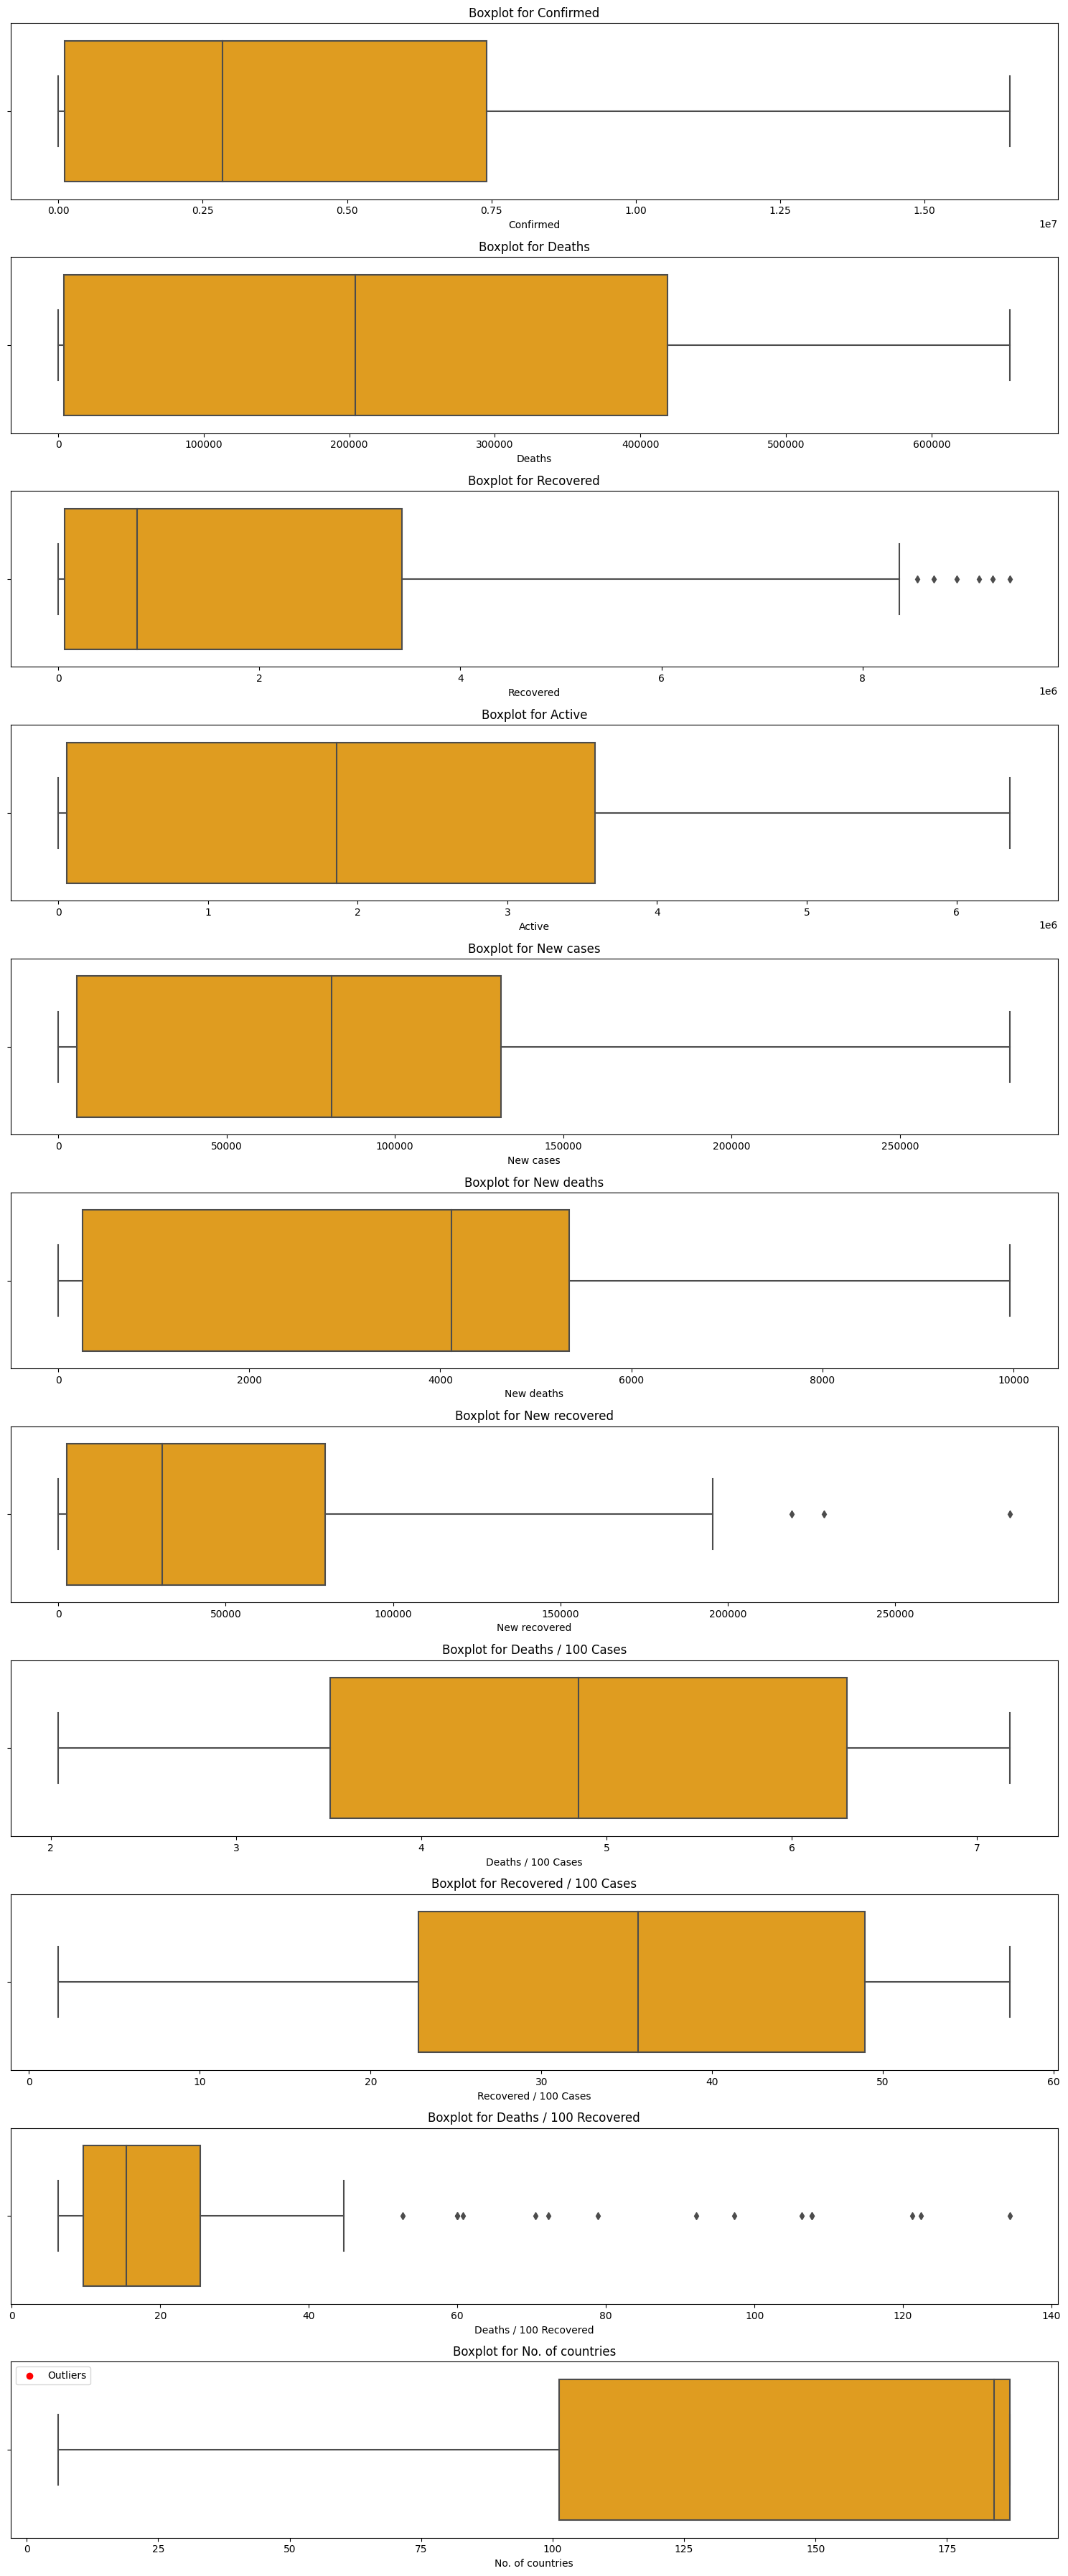

In [105]:
# Field: Day-Wise.
plot_outlier_boxplots(day_wise)

<ipython-input-96-8f0459503a11>:102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-96-8f0459503a11>:102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-96-8f0459503a11>:102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-96-8f0459503a11>:102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

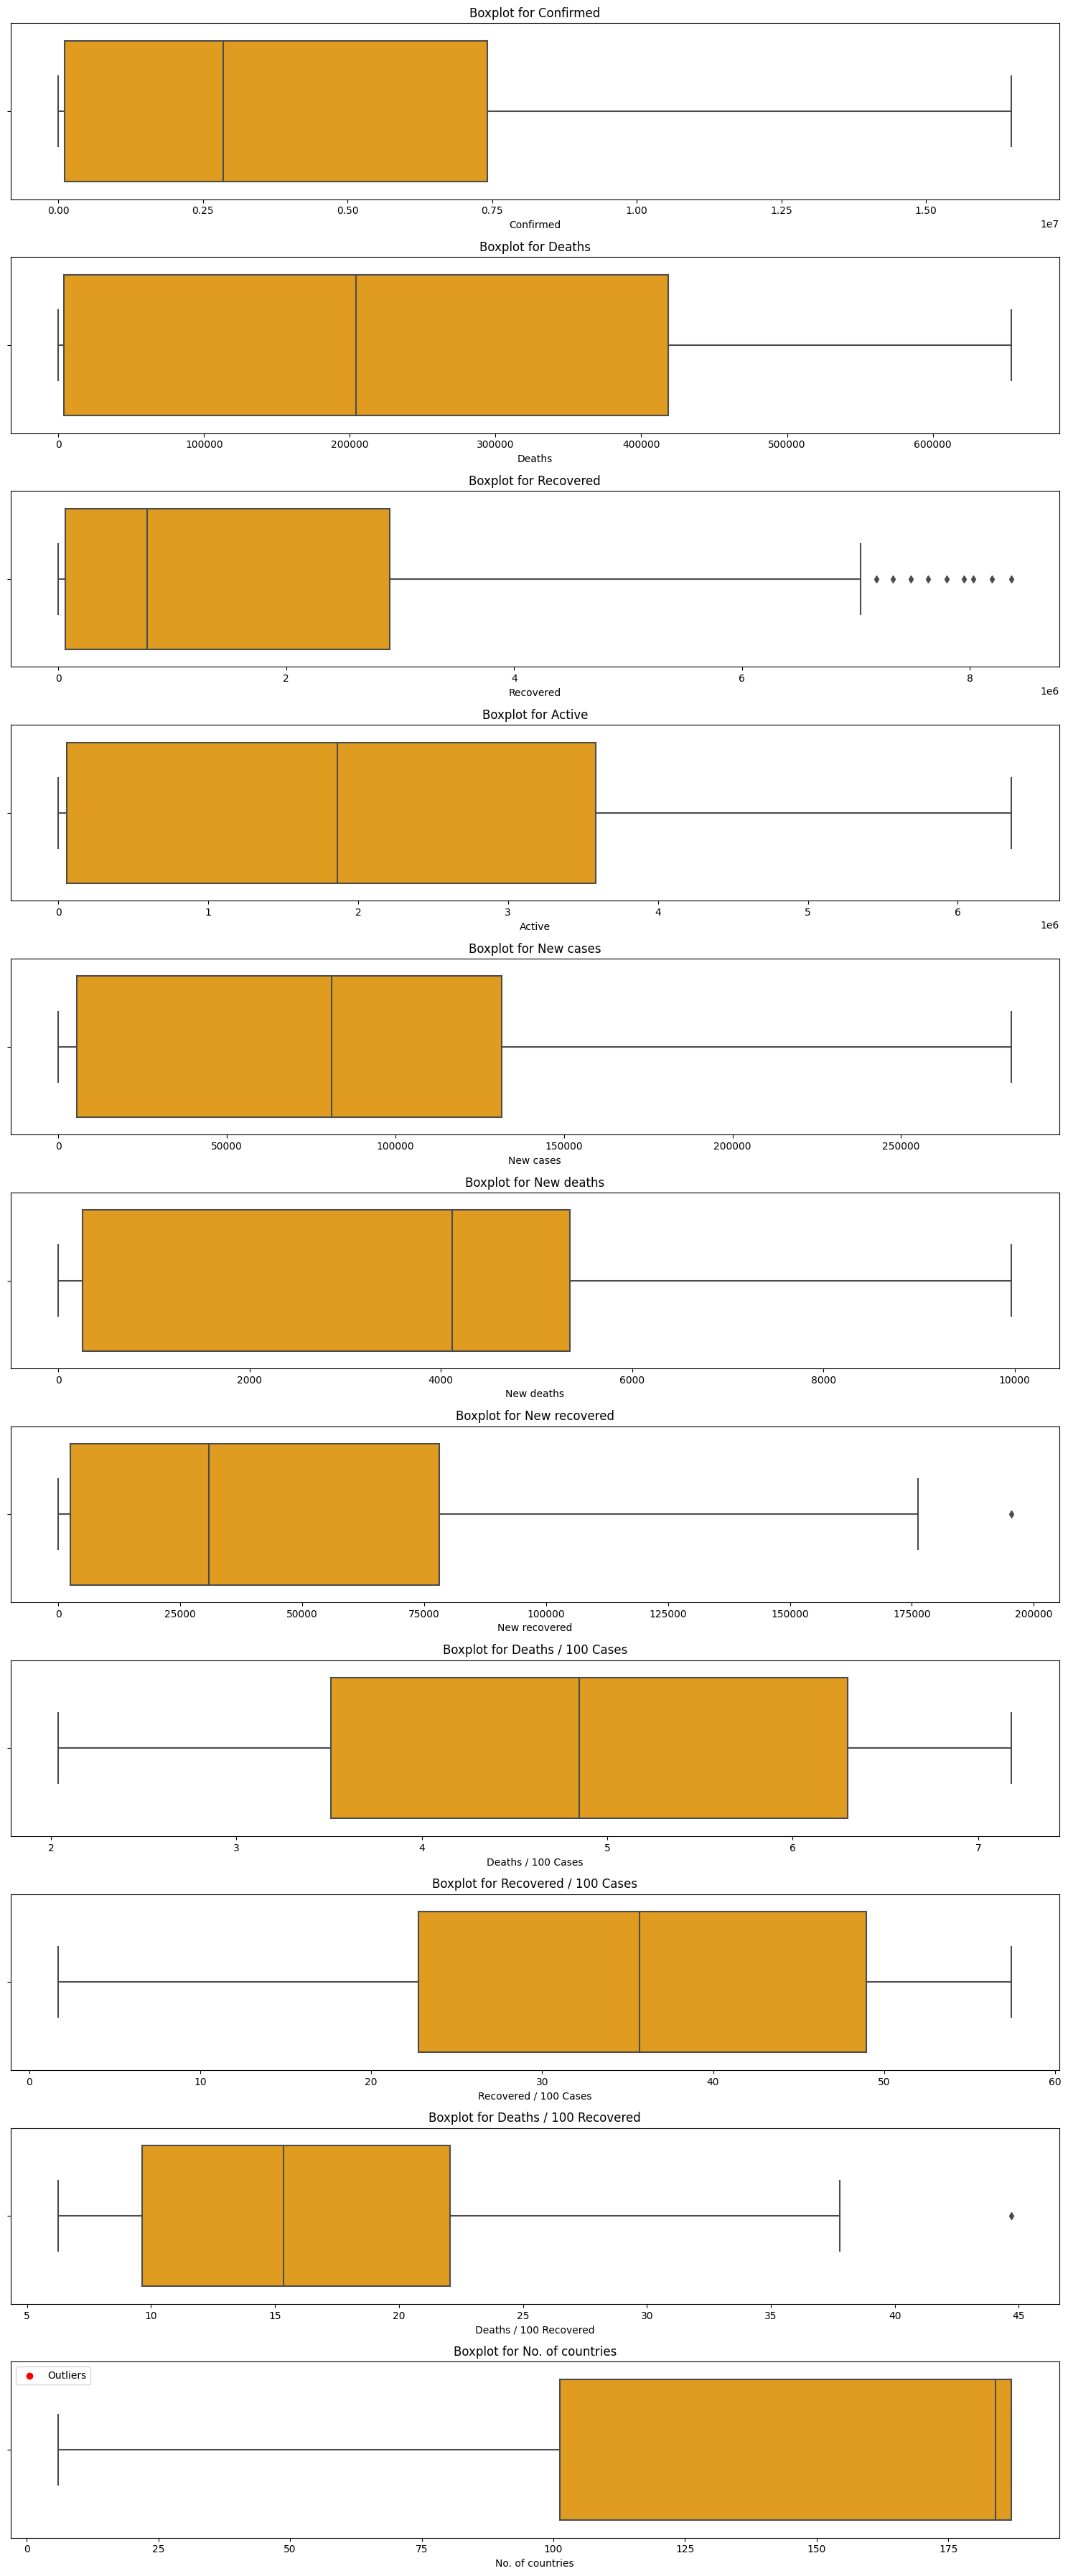

In [106]:
# Removing Outliers using Quartile Method.
day_wise = remove_outliers(day_wise)

# Checking for outliers.
plot_outlier_boxplots(day_wise)

In [107]:
# Creating Color Scale.
color_scale = px.colors.qualitative.Set2

fig = px.line(day_wise,
              x = 'Date',
              y = ['Confirmed', 'Deaths', 'Recovered', 'Active'],
              color_discrete_sequence = color_scale)

# Chart Decoration.
fig.update_layout(title = 'COVID-19 Cases Progression Over Time',
                  xaxis_title = 'Date',
                  yaxis_title = 'Count',
                  legend_title = 'Category',
                  margin = dict(l = 50, t = 60, r = 20, b = 30))

# Show the Plot.
fig.show()

<font color = '#FFA500'>How can the ratio of population to the number of tests conducted be effectively represented graphically?</font>

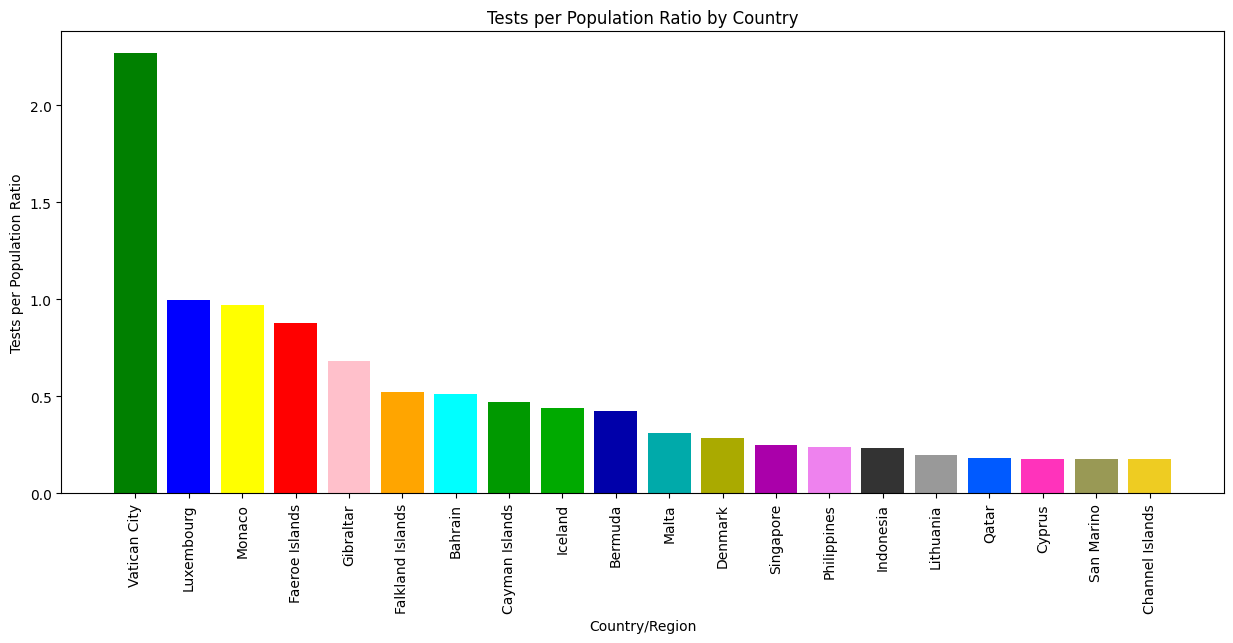

In [108]:
# Preparing data for visualization.
data = world_data.copy()

# Total Tests by Population.
data['TestsPerPopulationRatio'] = world_data.TotalTests / world_data.Population

# Top 20 cases.
data = data.sort_values(by = 'TestsPerPopulationRatio', ascending = False).iloc[ : 20]

# Create a bar chart.
plt.figure(figsize = (15, 6))
bars = plt.bar(data['Country/Region'], data.TestsPerPopulationRatio, color = ['Green', 'Blue', 'Yellow', 'Red', 'Pink', '#FFA500', '#0FF', '#090', '#0A0', '#00A', '#0AA', '#AA0', '#A0A', 'violet', '#333', '#999', '#005AFF', '#F3B', '#995', '#EC2'])

# Customize the plot.
plt.title('Tests per Population Ratio by Country')
plt.xlabel('Country/Region')
plt.ylabel('Tests per Population Ratio')
plt.xticks(rotation = 90) # Rotate x-axis labels for better readability.

# Show the plot.
plt.show()

<font color = '#FFA500'>Which nations have been significantly impacted by the coronavirus?</font>

In [109]:
def create_pie_subplot(ax, labels, sizes, title):
  '''
  Create a pie chart subplot on the given axis.
  ---
  # Parameters:
  - ax (matplotlib.axes._subplots.AxesSubplot): The axis on which to create the pie chart.
  - labels (list): A list of labels for each wedge in the pie chart.
  - sizes (list): A list of sizes (values) for each wedge in the pie chart.
  - title (str): The title of the pie chart subplot.
  ---
  # Returns:
  - None
  '''

  ax.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle = 90, colors = colors)
  ax.axis('equal')
  ax.set_title(title)

In [110]:
world_data.NewCases.unique()

array([  nan, 6590., 1282.,   20.,   30.])

In [111]:
world_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country/Region    209 non-null    object 
 1   Continent         209 non-null    object 
 2   Population        209 non-null    float64
 3   TotalCases        209 non-null    int64  
 4   NewCases          204 non-null    float64
 5   TotalDeaths       209 non-null    float64
 6   NewDeaths         204 non-null    float64
 7   TotalRecovered    209 non-null    float64
 8   NewRecovered      204 non-null    float64
 9   ActiveCases       209 non-null    float64
 10  Serious,Critical  209 non-null    float64
 11  Tot Cases/1M pop  209 non-null    float64
 12  Deaths/1M pop     209 non-null    float64
 13  TotalTests        209 non-null    float64
 14  Tests/1M pop      209 non-null    float64
 15  WHO Region        209 non-null    object 
dtypes: float64(12), int64(1), object(3)
memory u

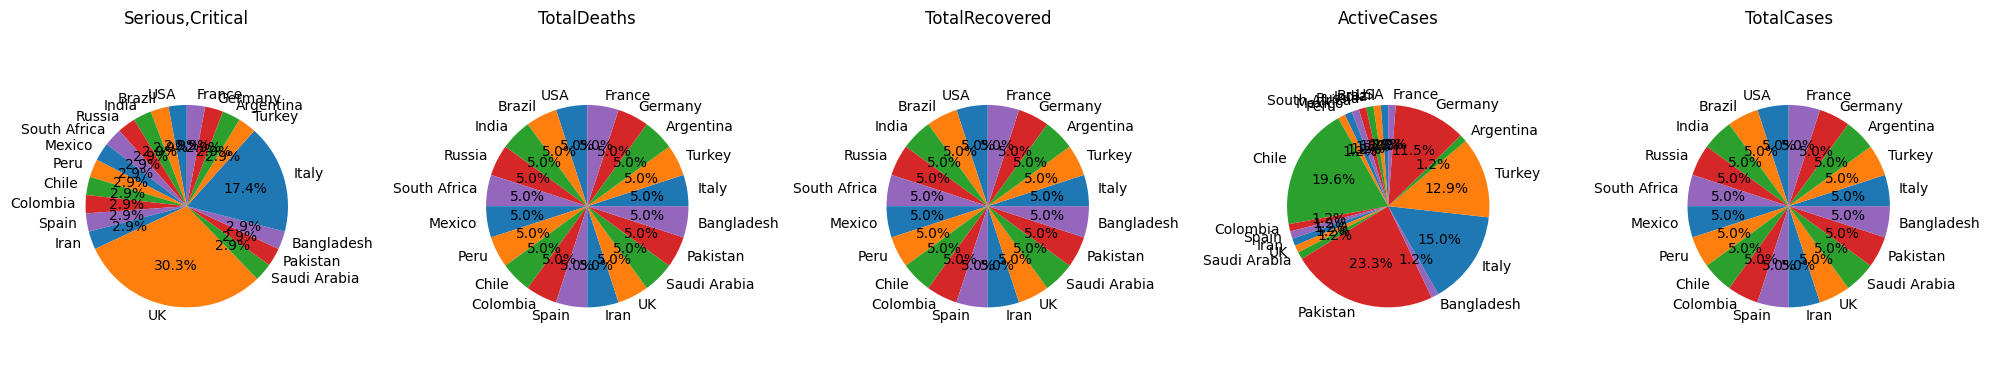

In [112]:
# Define the colors for the pie charts.
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Top 20 records.
data = world_data.iloc[ : 20]

# Create subplots for each field.
fig, axs = plt.subplots(1, 5, figsize = (20, 4))

# Loop through each field and create a pie chart subplot.
fields = ['Serious,Critical', 'TotalDeaths', 'TotalRecovered', 'ActiveCases', 'TotalCases']
for i, field in enumerate(fields):
    create_pie_subplot(axs[i], data['Country/Region'], data[field], field)

# Adjust layout to prevent overlap.
plt.tight_layout()

# Display the subplots.
plt.show()